# Laboratorio No. 3 - Data Science

Manuel Rodas - 21509 / Sebastián Solorzano - 21826

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf

### Carga de datos

In [3]:
def limpiar_datos(df):
    for col in df.columns[1:]:
        df[col] = df[col].str.replace(' ', '', regex=True)
        df[col] = df[col].str.replace(',', '.', regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [4]:
consumos_df = pd.read_csv('consumo.csv', sep=';', encoding='utf-8')
consumos_df = consumos_df.dropna(axis=1, how='all')
consumos_df = consumos_df[['Fecha', 'Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petr�leo']]
consumos_df = limpiar_datos(consumos_df)
consumos_df.head()

Fecha  Gasolina regular  Gasolina superior  Diesel bajo azufre  \
0  ene/2000         202645.20          308156.82                 0.0   
1  feb/2000         205530.96          307766.31                 0.0   
2  mar/2000         229499.56          331910.29                 0.0   
3  abr/2000         210680.40          315648.08                 0.0   
4  may/2000         208164.34          319667.97                 0.0   

   Gas licuado de petr�leo  
0                194410.48  
1                174710.55  
2                189234.07  
3                174330.61  
4                191745.15

In [5]:
importaciones_df1 = pd.read_csv('importacion.csv', sep=';', encoding='utf-8')
importaciones_df1 = importaciones_df1.dropna(axis=1, how='all')
importaciones_df1 = importaciones_df1[['Fecha', 'Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petr�leo']]
importaciones_df1 = limpiar_datos(importaciones_df1)
importaciones_df1.head()

Fecha  Gasolina regular  Gasolina superior  Diesel bajo azufre  \
0  ene/2001         177776.50          373963.96                 0.0   
1  feb/2001         123115.99          243091.07                 0.0   
2  mar/2001         161726.42          312084.38                 0.0   
3  abr/2001         127338.74          285054.89                 0.0   
4  may/2001         168730.19          300913.67                 0.0   

   Gas licuado de petr�leo  
0                194065.74  
1                170703.38  
2                161837.37  
3                163048.64  
4                171518.86

In [6]:
precios2024_df = pd.read_csv('precios2024.csv', sep=';', encoding='utf-8')
precios2024_df = precios2024_df.dropna(axis=1, how='all')

precios2023_df = pd.read_csv('precios2023.csv', sep=';', encoding='utf-8')
precios2023_df = precios2023_df.dropna(axis=1, how='all')

precios2022_df = pd.read_csv('precios2022.csv', sep=';', encoding='utf-8')
precios2022_df = precios2022_df.dropna(axis=1, how='all')

precios2021_df = pd.read_csv('precios2021.csv', sep=';', encoding='utf-8')
precios2021_df = precios2021_df.dropna(axis=1, how='all')

precios_df = pd.concat([precios2021_df, precios2022_df, precios2023_df, precios2024_df])
precios_df = precios_df[['FECHA', 'Superior', 'Regular', 'Diesel', 'Glp Cilindro 25Lbs.']]
precios_df.columns = ['Fecha', 'Gasolina superior', 'Gasolina regular', 'Diesel', 'Gas licuado de petróleo']
precios_df = limpiar_datos(precios_df)
precios_df.head()


Fecha  Gasolina superior  Gasolina regular  Diesel  \
0  01/ene/2021              21.91             21.11   17.61   
1  02/ene/2021              21.91             21.11   17.61   
2  03/ene/2021              21.91             21.11   17.61   
3  04/ene/2021              21.91             21.11   17.61   
4  05/ene/2021              21.91             21.11   17.61   

   Gas licuado de petróleo  
0                     99.0  
1                     99.0  
2                     99.0  
3                     99.0  
4                     99.0

### Análisis exploratorio

In [7]:
def verificar_normalidad(df):
    resultados = {}
    for col in df.columns[1:]:
        stat, p_value = shapiro(df[col].dropna())
        resultados[col] = p_value
    return resultados

In [8]:
def graficar_datos(consumos_df, importaciones_df1, precios_df):
    plt.figure(figsize=(14, 10))
    
    # Graficar datos de consumo
    plt.subplot(3, 1, 1)
    consumos_df[['Fecha', 'Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petr�leo']].set_index('Fecha').plot(kind='line', ax=plt.gca())
    plt.title('Consumo de Combustibles')
    plt.xticks(rotation=45)
    
    # Graficar datos de importación
    plt.subplot(3, 1, 2)
    importaciones_df1[['Fecha', 'Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petr�leo']].set_index('Fecha').plot(kind='line', ax=plt.gca())
    plt.title('Importaciones de Combustibles')
    plt.xticks(rotation=45)
    
    # Graficar datos de precios
    plt.subplot(3, 1, 3)
    precios_df[['Fecha', 'Gasolina superior', 'Gasolina regular', 'Diesel', 'Gas licuado de petróleo']].set_index('Fecha').plot(kind='line', ax=plt.gca())
    plt.title('Precios de Combustibles')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analizar_picos(importaciones_df1):    
    importaciones_df2 = importaciones_df1.copy()

    # Convertir la columna 'Fecha' a datetime y establecerla como índice
    importaciones_df2['Fecha'] = pd.to_datetime(importaciones_df2['Fecha'], format='%b/%Y', errors='coerce')
    
    # Verificar si la conversión de fechas fue exitosa
    if importaciones_df2['Fecha'].isnull().all():
        print("Error: No se pudieron convertir las fechas. Verifique el formato de las fechas en el CSV.")
        return
    
    importaciones_df2.set_index('Fecha', inplace=True)
    
    # Agrupar datos por mes manualmente
    importaciones_mensuales = importaciones_df2[['Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petr�leo']].resample('M').sum()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=importaciones_mensuales)
    plt.title('Importaciones Mensuales de Combustibles')
    plt.xlabel('Fecha')
    plt.ylabel('Volumen')
    plt.xticks(rotation=45, ha='right')
    plt.show()
        
    # Filtrar por período de pandemia
    importaciones_pandemia = importaciones_mensuales.loc['2020-03':'2022-12']
    
    # Verificar si hay datos durante la pandemia
    if importaciones_pandemia.empty:
        print("No hay datos disponibles para el período de la pandemia.")
    else:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=importaciones_pandemia)
        plt.title('Importaciones durante la Pandemia')
        plt.xlabel('Fecha')
        plt.ylabel('Volumen')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()  # Ajustar el diseño para que no se corten etiquetas
        plt.show()

In [10]:
normalidad_consumo = verificar_normalidad(consumos_df)
normalidad_importacion = verificar_normalidad(importaciones_df1)
normalidad_precios = verificar_normalidad(precios_df)

print("Normalidad en datos de consumo:", normalidad_consumo)
print("Normalidad en datos de importación:", normalidad_importacion)
print("Normalidad en datos de precios:", normalidad_precios)

Normalidad en datos de consumo: {'Gasolina regular': 1.3333423045052765e-16, 'Gasolina superior': 3.3319368373273852e-12, 'Diesel bajo azufre': 9.332616072193326e-26, 'Gas licuado de petr�leo': 3.1577836482406835e-14}
Normalidad en datos de importación: {'Gasolina regular': 1.8343557582560277e-12, 'Gasolina superior': 2.6268341703425063e-05, 'Diesel bajo azufre': 1.1129243537452424e-24, 'Gas licuado de petr�leo': 1.985218327462084e-07}
Normalidad en datos de precios: {'Gasolina superior': 1.8635733529599887e-07, 'Gasolina regular': 8.969604447466781e-08, 'Diesel': 4.248561947101779e-09, 'Gas licuado de petróleo': 9.387398781364746e-29}


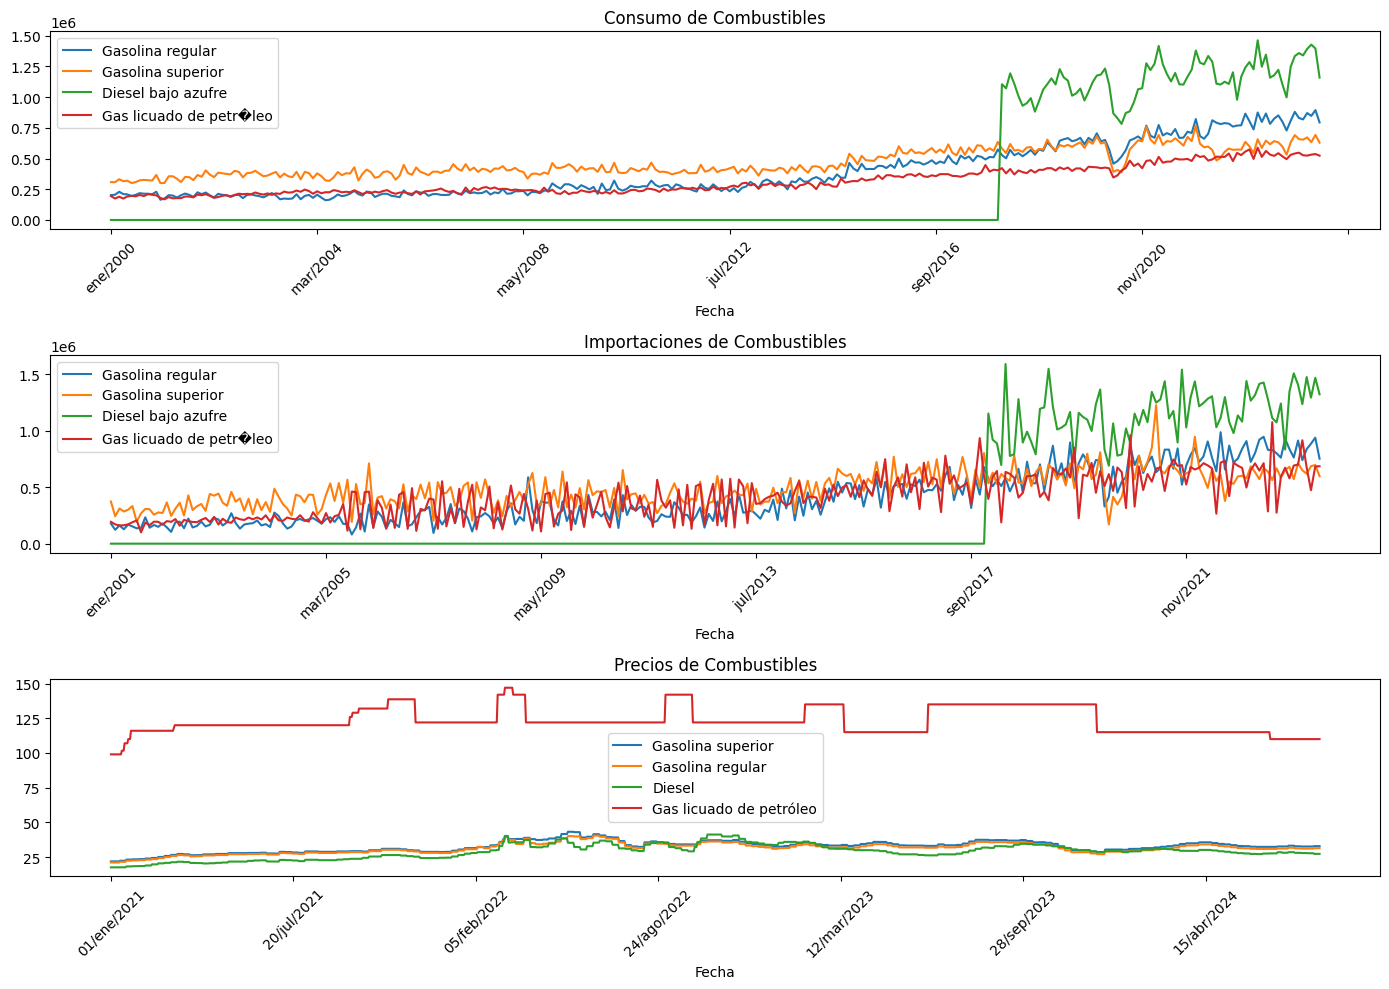

In [11]:
graficar_datos(consumos_df, importaciones_df1, precios_df)

C:\Users\rodas\AppData\Local\Temp\ipykernel_47060\2716891693.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  importaciones_mensuales = importaciones_df2[['Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petr�leo']].resample('M').sum()


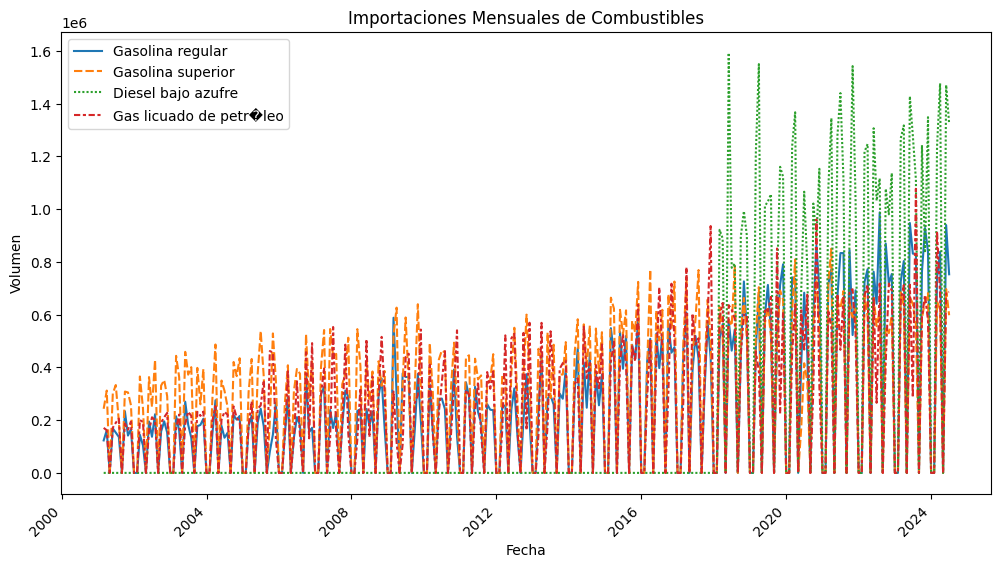

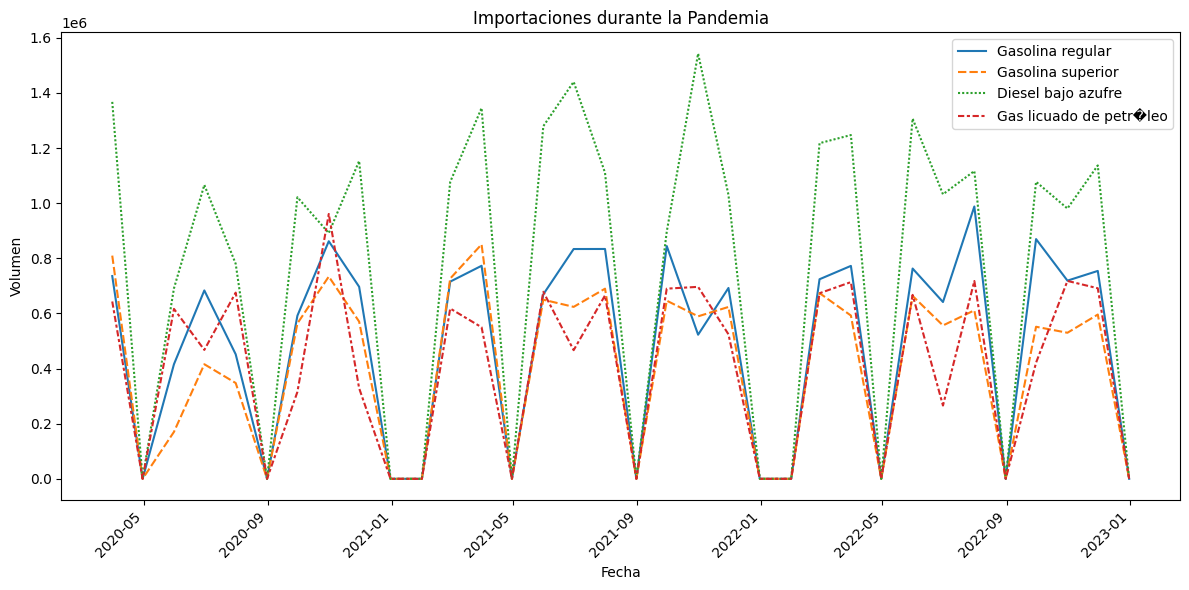

In [12]:
analizar_picos(importaciones_df1)

### Serie de consumos

In [13]:
consumos_df2 = consumos_df.copy()
# Convertir la columna 'Fecha' a datetime y establecerla como índice
consumos_df2['Fecha'] = pd.to_datetime(consumos_df2['Fecha'], format='%b/%Y', errors='coerce')

# Verificar si la conversión de fechas fue exitosa
if consumos_df2['Fecha'].isnull().all():
    print("Error: No se pudieron convertir las fechas. Verifique el formato de las fechas en el CSV.")

consumos_df2.set_index('Fecha', inplace=True)

In [14]:
# Inicio, fin y frecuencia de los datos
print("Inicio de los datos:", consumos_df2.index.min())
print("Fin de los datos:", consumos_df2.index.max())
print("Frecuencia de los datos:", consumos_df2.index.to_series().diff().value_counts())

Inicio de los datos: 2000-02-01 00:00:00
Fin de los datos: 2024-06-01 00:00:00
Frecuencia de los datos: Fecha
31 days    49
30 days    48
28 days    18
29 days     7
Name: count, dtype: int64


C:\Users\rodas\AppData\Local\Temp\ipykernel_47060\2656707399.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sns.lineplot(data=consumos_df2.resample('M').sum())


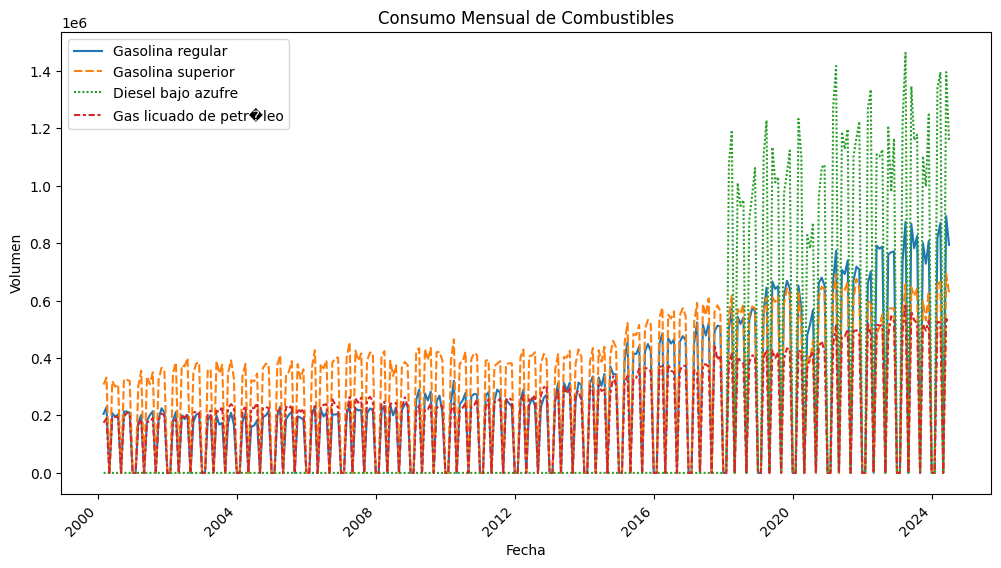

In [15]:
# Gráfico de la Serie consumos
plt.figure(figsize=(12, 6))
sns.lineplot(data=consumos_df2.resample('M').sum())
plt.title('Consumo Mensual de Combustibles')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45, ha='right')
plt.show()

C:\Users\rodas\AppData\Local\Temp\ipykernel_47060\986547926.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  consumo_mensual = consumos_df2.resample('M').sum()


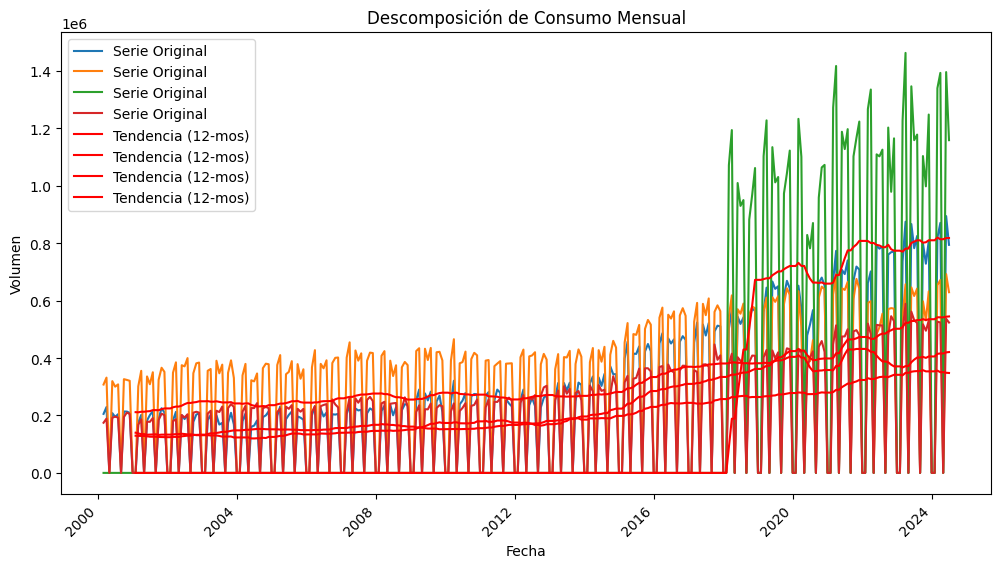

In [16]:
# Descomposición de la Serie
consumo_mensual = consumos_df2.resample('M').sum()
consumo_mensual_decomp = consumo_mensual.rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(consumo_mensual, label='Serie Original')
plt.plot(consumo_mensual_decomp, label='Tendencia (12-mos)', color='red')
plt.legend()
plt.title('Descomposición de Consumo Mensual')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45, ha='right')
plt.show()

In [17]:
# Transformación de la Serie
consumo_mensual_log = np.log(consumo_mensual.replace(0, np.nan))

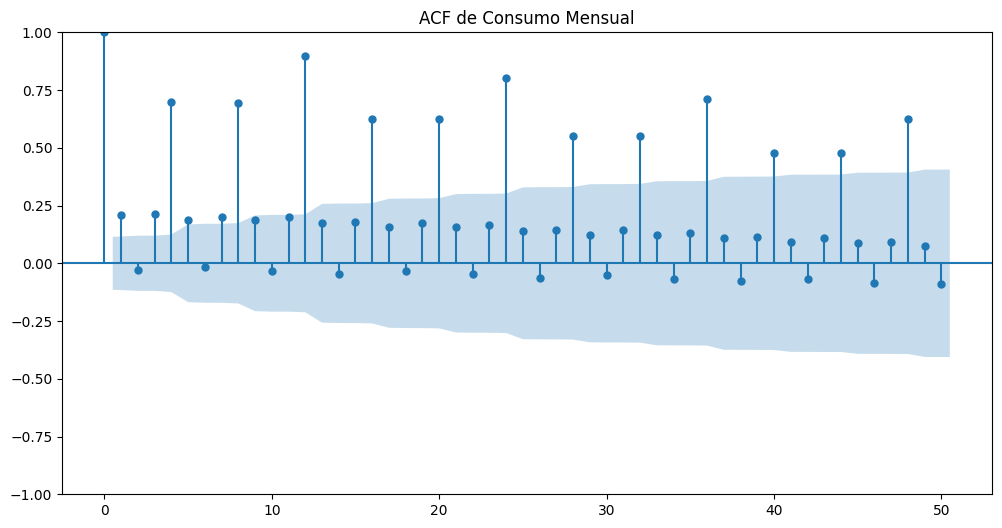

Estadístico ADF: 1.7800966484477552
Valor p: 0.9983087141941657


In [18]:
# Estacionariedad en Media
consumo_mensual_columna = consumo_mensual['Gasolina regular']

# Gráfico de ACF
plt.figure(figsize=(12, 6))
plot_acf(consumo_mensual_columna.dropna(), lags=50, ax=plt.gca())
plt.title('ACF de Consumo Mensual')
plt.show()

# Prueba de Estacionariedad ADF
adf_result = adfuller(consumo_mensual_columna.dropna())
print(f'Estadístico ADF: {adf_result[0]}')
print(f'Valor p: {adf_result[1]}')

In [19]:
# Estacionariedad en Media
consumo_mensual_columna = consumo_mensual['Gasolina regular'].dropna()

# Parámetros del Modelo ARIMA
auto_model = auto_arima(consumo_mensual_columna, seasonal=True, m=12)
print(auto_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  293
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -3343.207
Date:                                 Tue, 27 Aug 2024   AIC                           6696.413
Time:                                         10:51:40   BIC                           6714.587
Sample:                                     02-29-2000   HQIC                          6703.703
                                          - 06-30-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6511      0.046    -14.063      0.000      -0.742      -0

c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


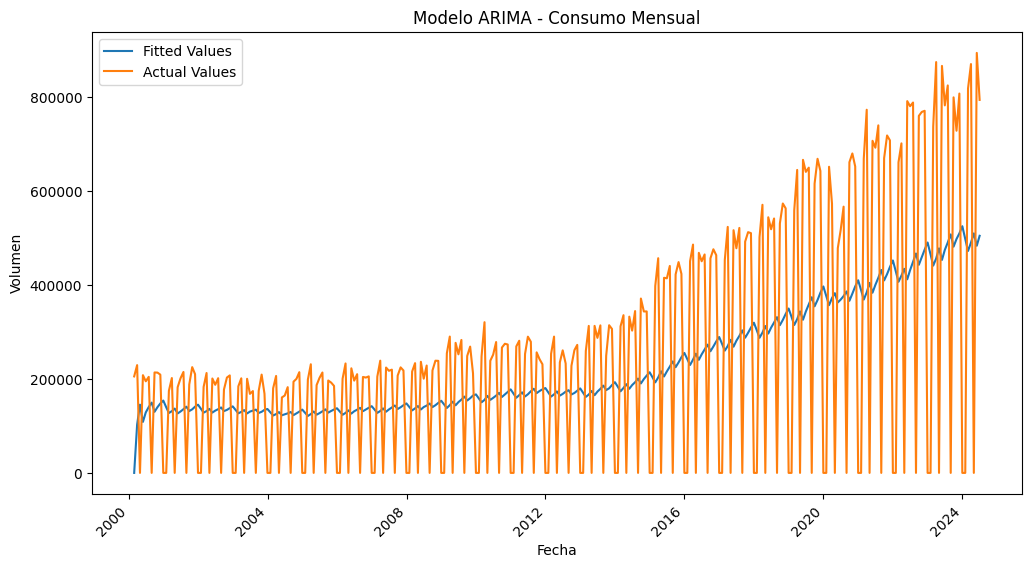

AIC: 8004.2573022507595
BIC: 8011.610809855296


In [20]:
# Estacionariedad en Media
consumo_mensual_columna = consumo_mensual['Gasolina regular'].dropna()

# Modelos ARIMA
best_model = ARIMA(consumo_mensual_columna, order=auto_model.order)
best_fit = best_model.fit()

plt.figure(figsize=(12, 6))
plt.plot(best_fit.fittedvalues, label='Fitted Values')
plt.plot(consumo_mensual_columna, label='Actual Values')
plt.legend()
plt.title('Modelo ARIMA - Consumo Mensual')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45, ha='right')
plt.show()

print(f'AIC: {best_fit.aic}')
print(f'BIC: {best_fit.bic}')

10:51:41 - cmdstanpy - INFO - Chain [1] start processing
10:51:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain t

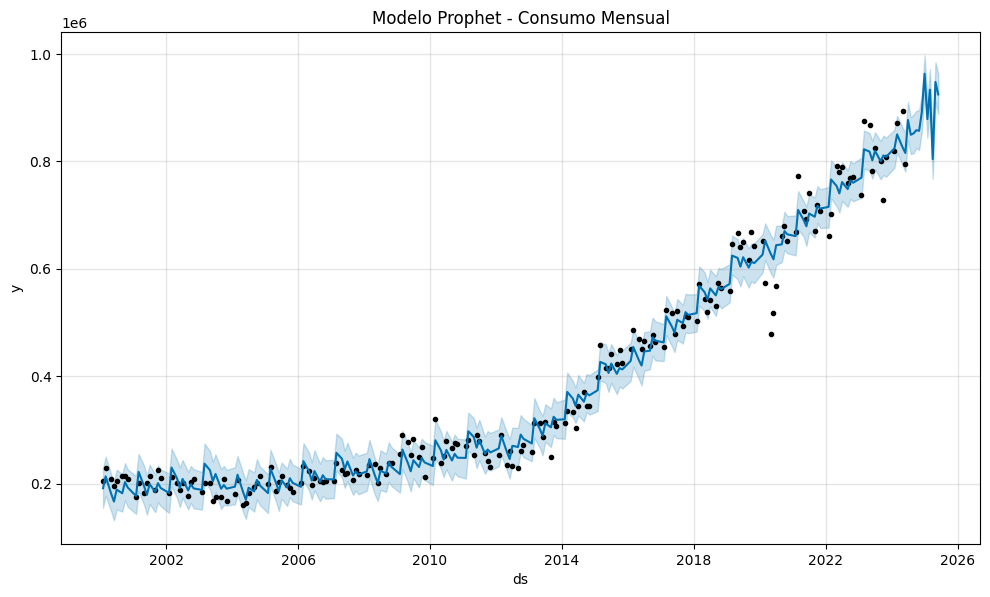

In [21]:
# Crear el DataFrame para Prophet
consumo_df_prophet = consumos_df[['Fecha', 'Gasolina regular']].copy()
consumo_df_prophet['Fecha'] = pd.to_datetime(consumo_df_prophet['Fecha'], format='%b/%Y', errors='coerce')
consumo_df_prophet = consumo_df_prophet.dropna(subset=['Fecha'])  # Eliminar filas con fechas inválidas
consumo_df_prophet = consumo_df_prophet.rename(columns={'Fecha': 'ds', 'Gasolina regular': 'y'})
consumo_df_prophet = consumo_df_prophet.dropna(subset=['y'])  # Eliminar filas con valores 'y' NaN

# Modelo Prophet
prophet_model = Prophet()
prophet_model.fit(consumo_df_prophet)

# DataFrame para el futuro
future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

# Gráfico del pronóstico
fig = prophet_model.plot(forecast)
plt.title('Modelo Prophet - Consumo Mensual')
plt.show()

### Serie de importaciones

In [22]:
importaciones_df2 = importaciones_df1.copy()

importaciones_df2['Fecha'] = pd.to_datetime(importaciones_df2['Fecha'], format='%b/%Y', errors='coerce')
importaciones_df2.set_index('Fecha', inplace=True)

In [23]:
# Inicio, fin y frecuencia de los datos
print("Inicio de los datos:", importaciones_df2.index.min())
print("Fin de los datos:", importaciones_df2.index.max())
print("Frecuencia de los datos:", importaciones_df2.index.to_series().diff().value_counts())

Inicio de los datos: 2001-02-01 00:00:00
Fin de los datos: 2024-06-01 00:00:00
Frecuencia de los datos: Fecha
31 days    47
30 days    46
28 days    18
29 days     6
Name: count, dtype: int64


C:\Users\rodas\AppData\Local\Temp\ipykernel_47060\3567930753.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sns.lineplot(data=importaciones_df2.resample('M').sum())


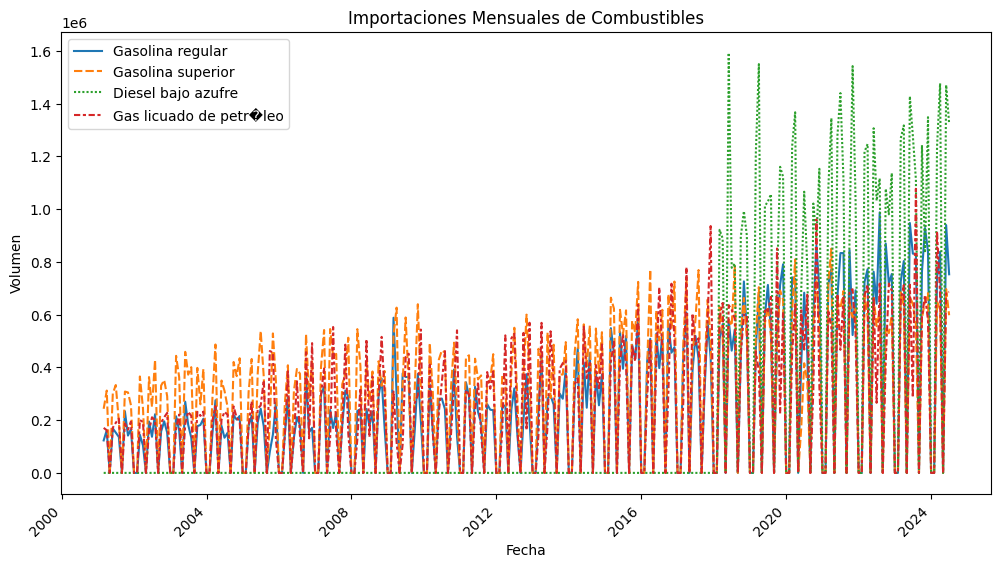

In [24]:
# Gráfico de la Serie
plt.figure(figsize=(12, 6))
sns.lineplot(data=importaciones_df2.resample('M').sum())
plt.title('Importaciones Mensuales de Combustibles')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45, ha='right')
plt.show()

C:\Users\rodas\AppData\Local\Temp\ipykernel_47060\4285456486.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  importaciones_mensuales = importaciones_df2.resample('M').sum()


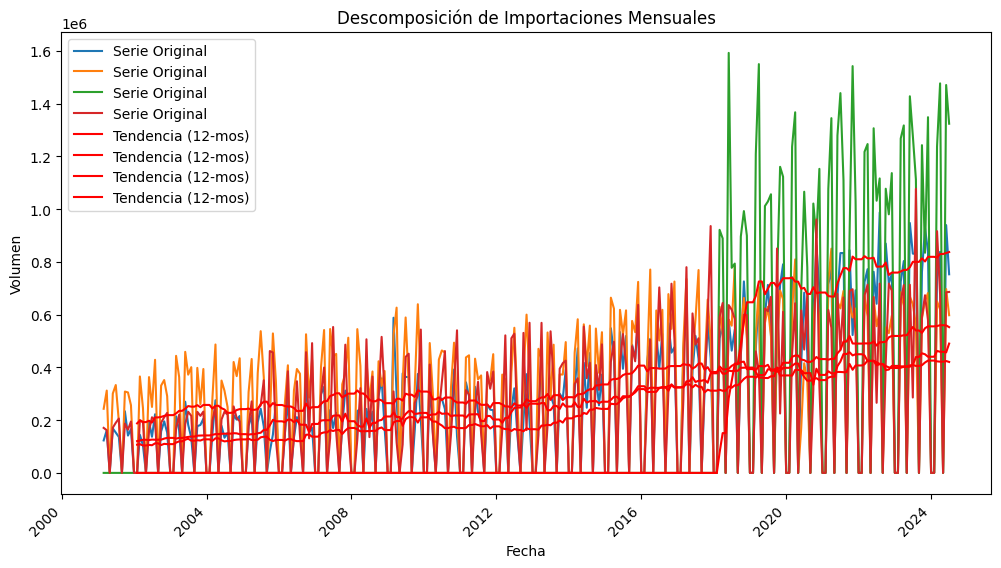

In [25]:
# Descomposición de la Serie
importaciones_mensuales = importaciones_df2.resample('M').sum()
importaciones_mensuales_decomp = importaciones_mensuales.rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(importaciones_mensuales, label='Serie Original')
plt.plot(importaciones_mensuales_decomp, label='Tendencia (12-mos)', color='red')
plt.legend()
plt.title('Descomposición de Importaciones Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45, ha='right')
plt.show()

In [26]:
# Transformación de la Serie
importaciones_mensuales_log = np.log(importaciones_mensuales.replace(0, np.nan))

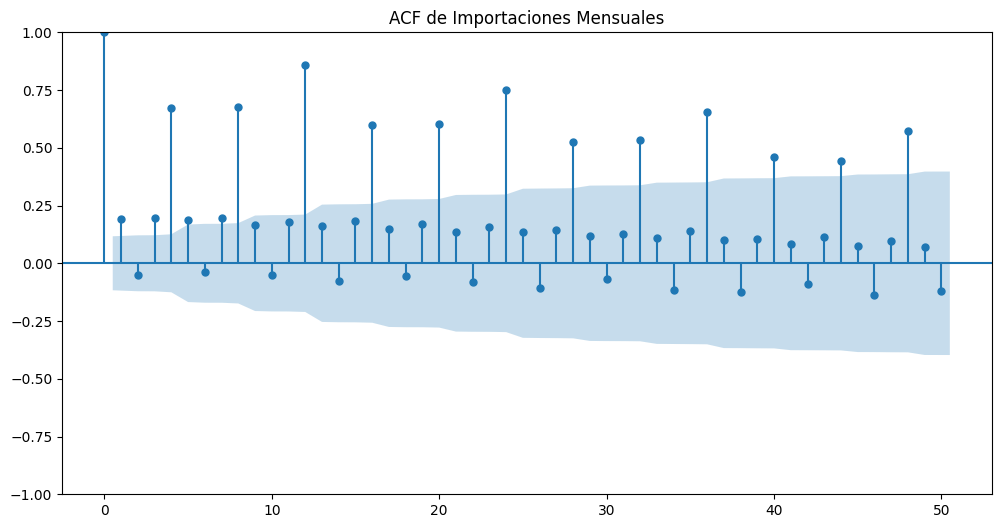

Estadístico ADF: 1.0617580625385428
Valor p: 0.9948766577533587


In [27]:
importaciones_mensuales_columna = importaciones_mensuales['Gasolina regular']

# Estacionariedad en Media
plt.figure(figsize=(12, 6))
plot_acf(importaciones_mensuales_columna.dropna(), lags=50, ax=plt.gca())
plt.title('ACF de Importaciones Mensuales')
plt.show()

adf_result = adfuller(importaciones_mensuales_columna.dropna())
print(f'Estadístico ADF: {adf_result[0]}')
print(f'Valor p: {adf_result[1]}')

In [28]:
# Parametros del Modelo ARIMA
auto_model = auto_arima(importaciones_mensuales_columna, seasonal=True, m=12)
print(auto_model.summary())

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  281
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood               -3443.287
Date:                    Tue, 27 Aug 2024   AIC                           6892.574
Time:                            10:51:56   BIC                           6903.358
Sample:                        02-28-2001   HQIC                          6896.905
                             - 06-30-2024                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.988e+04   4023.890      4.941      0.000     1.2e+04    2.78e+04
ma.S.L12      -0.3716      0.054     -6.831      0.000      -0.478      -0.265
sigma2      8.723e+0

c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


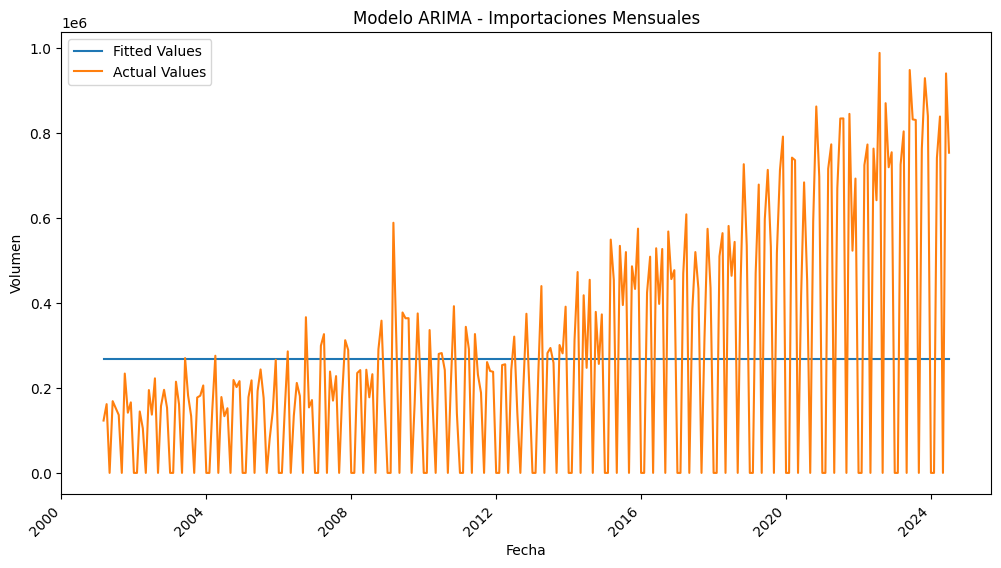

AIC: 9124.85103962795
BIC: 9132.127748966619


In [29]:
# Modelos ARIMA
best_model = ARIMA(importaciones_mensuales_columna, order=auto_model.order)
best_fit = best_model.fit()

plt.figure(figsize=(12, 6))
plt.plot(best_fit.fittedvalues, label='Fitted Values')
plt.plot(importaciones_mensuales_columna, label='Actual Values')
plt.legend()
plt.title('Modelo ARIMA - Importaciones Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45, ha='right')
plt.show()

print(f'AIC: {best_fit.aic}')
print(f'BIC: {best_fit.bic}')

10:51:56 - cmdstanpy - INFO - Chain [1] start processing
10:51:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain t

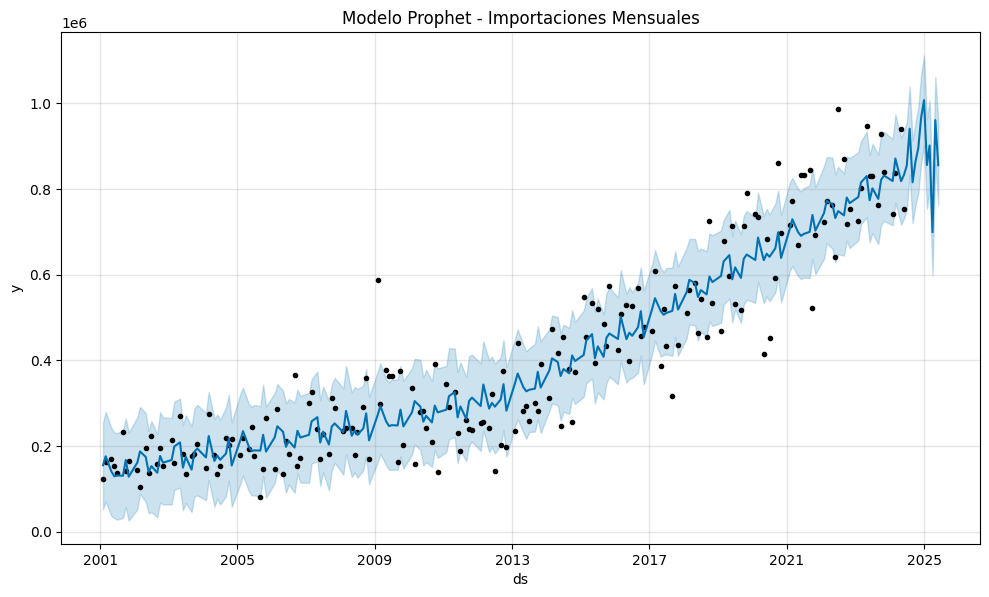

In [30]:
# Modelo Prophet
importaciones_df_prophet = importaciones_df1[['Fecha', 'Gasolina regular']].copy()
importaciones_df_prophet['Fecha'] = pd.to_datetime(importaciones_df_prophet['Fecha'], format='%b/%Y', errors='coerce')
importaciones_df_prophet = importaciones_df_prophet.dropna(subset=['Fecha'])  # Eliminar filas con fechas inválidas
importaciones_df_prophet = importaciones_df_prophet.rename(columns={'Fecha': 'ds', 'Gasolina regular': 'y'})
importaciones_df_prophet = importaciones_df_prophet.dropna(subset=['y'])  # Eliminar filas con valores 'y' NaN

# Modelo Prophet
prophet_model = Prophet()
prophet_model.fit(importaciones_df_prophet)
future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

# Gráfico del pronóstico
fig = prophet_model.plot(forecast)
plt.title('Modelo Prophet - Importaciones Mensuales')
plt.show()

### Serie de Precios

In [31]:
precios_df2 = precios_df.copy()

# Definir un mapa de meses en español a inglés
month_translation = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr',
    'may': 'May', 'jun': 'Jun', 'jul': 'Jul', 'ago': 'Aug',
    'sep': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

precios_df2['Fecha'] = precios_df2['Fecha'].str.lower().replace(month_translation, regex=True)
precios_df2['Fecha'] = pd.to_datetime(precios_df2['Fecha'], format='%d/%b/%Y', errors='coerce')
precios_df2.set_index('Fecha', inplace=True)

In [32]:
# Inicio, fin y frecuencia de los datos
print("Inicio de los datos:", precios_df2.index.min())
print("Fin de los datos:", precios_df2.index.max())
print("Frecuencia de los datos:", precios_df2.index.to_series().diff().value_counts())

Inicio de los datos: 2021-01-01 00:00:00
Fin de los datos: 2024-08-18 00:00:00
Frecuencia de los datos: Fecha
1 days    1325
Name: count, dtype: int64


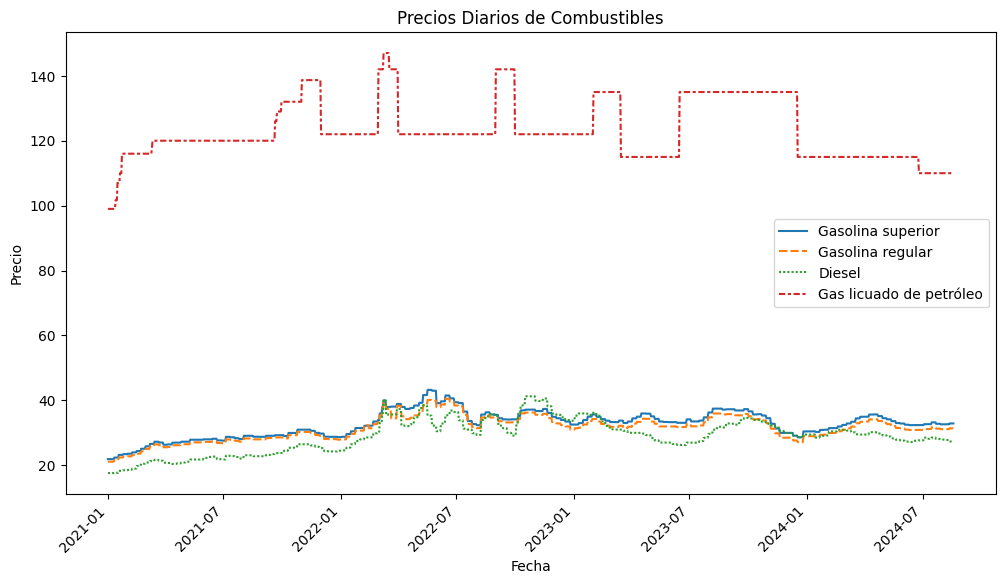

In [33]:
# Gráfico de la Serie de Precios
plt.figure(figsize=(12, 6))
sns.lineplot(data=precios_df2.resample('D').mean())
plt.title('Precios Diarios de Combustibles')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.xticks(rotation=45, ha='right')
plt.show()

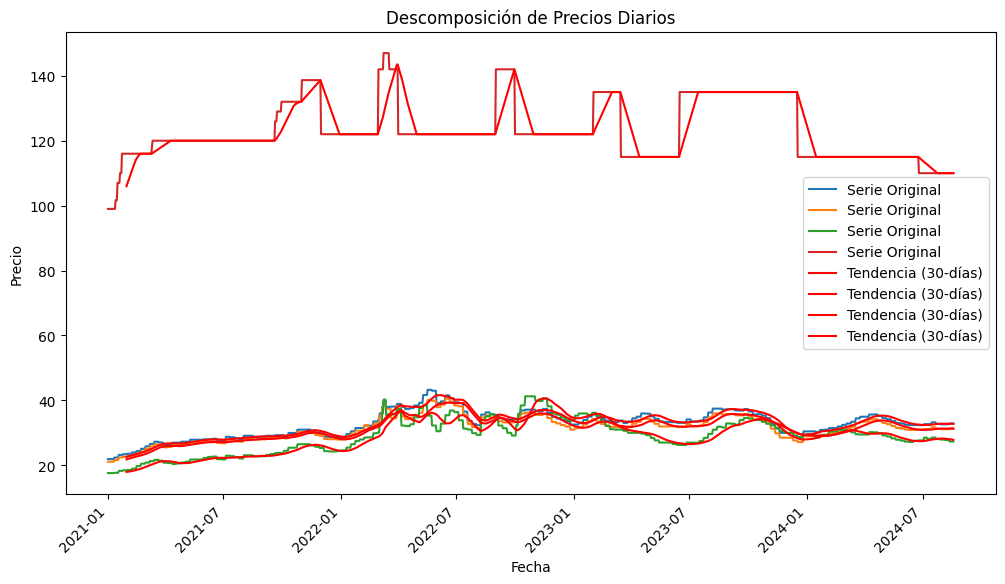

In [34]:
# Descomposición de la Serie
precios_diarios = precios_df2.resample('D').mean()
precios_diarios_decomp = precios_diarios.rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(precios_diarios, label='Serie Original')
plt.plot(precios_diarios_decomp, label='Tendencia (30-días)', color='red')
plt.legend()
plt.title('Descomposición de Precios Diarios')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.xticks(rotation=45, ha='right')
plt.show()

In [35]:
# Transformación de la Serie
precios_diarios_log = np.log(precios_diarios.replace(0, np.nan))

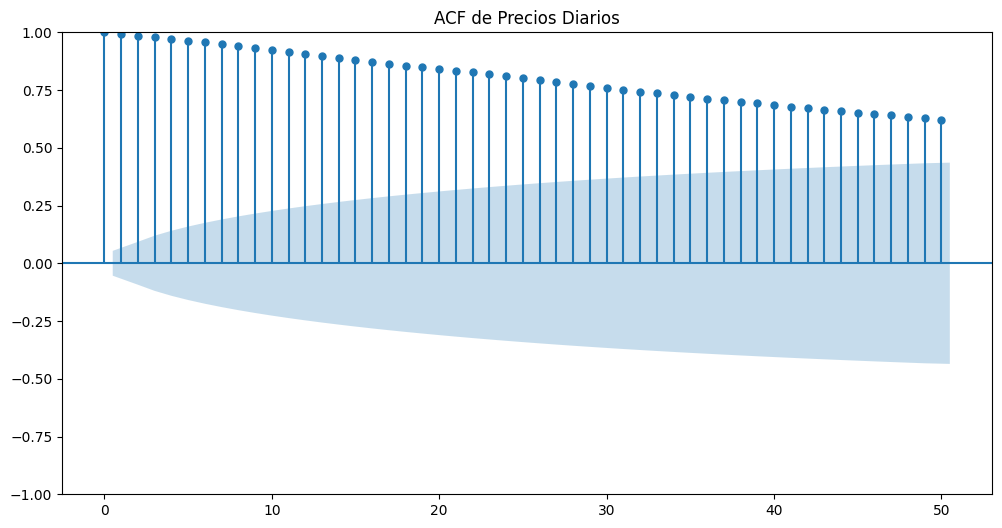

Estadístico ADF: -2.738897188477561
Valor p: 0.06754580252780054


In [36]:
# Estacionariedad en Media
precios_diarios_columna = precios_diarios['Gasolina regular']
plt.figure(figsize=(12, 6))
plot_acf(precios_diarios_columna.dropna(), lags=50, ax=plt.gca())
plt.title('ACF de Precios Diarios')
plt.show()

# Prueba de Estacionariedad ADF
adf_result = adfuller(precios_diarios_columna.dropna())
print(f'Estadístico ADF: {adf_result[0]}')
print(f'Valor p: {adf_result[1]}')

In [37]:
# Parámetros del Modelo ARIMA
auto_model = auto_arima(precios_diarios_columna, seasonal=True, m=12)
print(auto_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 1326
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -486.214
Date:                              Tue, 27 Aug 2024   AIC                            978.427
Time:                                      10:52:57   BIC                            993.995
Sample:                                  01-01-2021   HQIC                           984.263
                                       - 08-18-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7674      0.119     -6.437      0.000      -1.001      -0.534
ma.S.L12       0.72

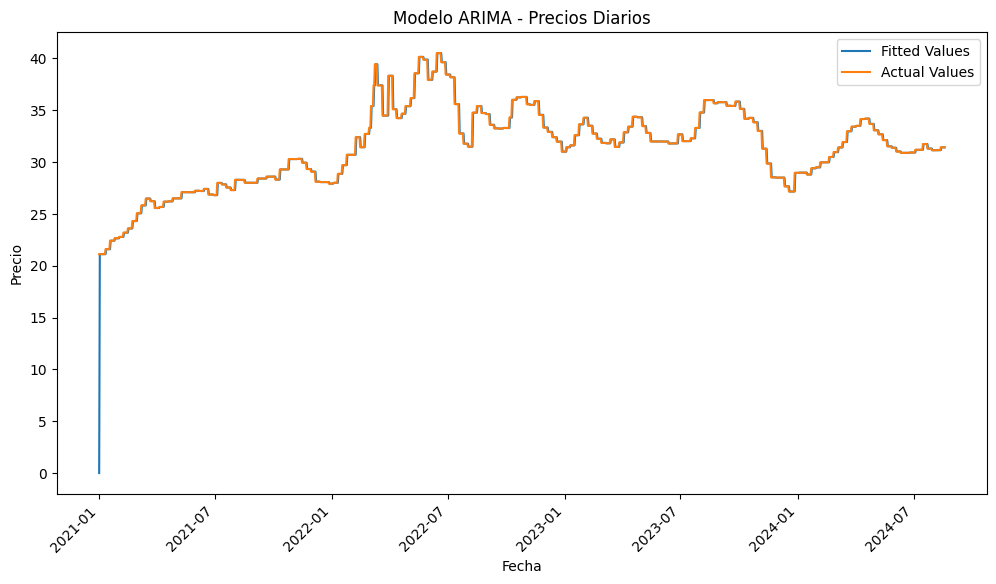

AIC: 981.6637501820383
BIC: 986.8529179204586


In [38]:
# Modelos ARIMA
best_model = ARIMA(precios_diarios_columna, order=auto_model.order)
best_fit = best_model.fit()

plt.figure(figsize=(12, 6))
plt.plot(best_fit.fittedvalues, label='Fitted Values')
plt.plot(precios_diarios_columna, label='Actual Values')
plt.legend()
plt.title('Modelo ARIMA - Precios Diarios')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.xticks(rotation=45, ha='right')
plt.show()

print(f'AIC: {best_fit.aic}')
print(f'BIC: {best_fit.bic}')

10:52:57 - cmdstanpy - INFO - Chain [1] start processing
10:52:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


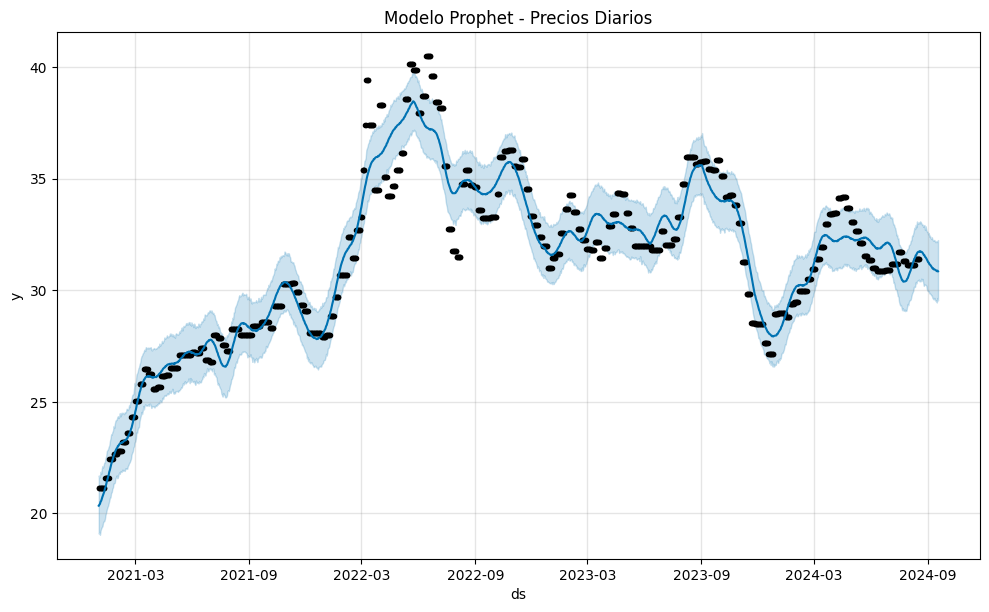

In [39]:
# Modelo Prophet
precios_df_prophet = precios_df[['Fecha', 'Gasolina regular']].copy()
precios_df_prophet['Fecha'] = precios_df_prophet['Fecha'].str.lower().replace(month_translation, regex=True)
precios_df_prophet['Fecha'] = pd.to_datetime(precios_df_prophet['Fecha'], format='%d/%b/%Y', errors='coerce')
precios_df_prophet = precios_df_prophet.dropna(subset=['Fecha'])  # Eliminar filas con fechas inválidas
precios_df_prophet = precios_df_prophet.rename(columns={'Fecha': 'ds', 'Gasolina regular': 'y'})
precios_df_prophet = precios_df_prophet.dropna(subset=['y'])  # Eliminar filas con valores 'y' NaN

# Modelo Prophet
prophet_model = Prophet()
prophet_model.fit(precios_df_prophet)
future = prophet_model.make_future_dataframe(periods=30, freq='D')
forecast = prophet_model.predict(future)

# Gráfico del pronóstico
fig = prophet_model.plot(forecast)
plt.title('Modelo Prophet - Precios Diarios')
plt.show()

## Modelos LSTM 

In [45]:
def crear_ventanas(datos, ventana):
    X = []
    y = []
    for i in range(len(datos) - ventana):
        X.append(datos[i:(i + ventana)])
        y.append(datos[i + ventana])
    return np.array(X), np.array(y)

In [46]:
def construir_modelo_lstm(units, dropout_rate, learning_rate, input_shape):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [47]:
def entrenar_modelo_lstm(X_train, y_train, X_val, y_val, model):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
    return history

In [48]:
def preprocesar_series(series, ventana=12):
    scaler = MinMaxScaler(feature_range=(0, 1))
    serie_escalada = scaler.fit_transform(series.values.reshape(-1, 1))
    X, y = crear_ventanas(serie_escalada, ventana)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val, scaler

### Series de Consumo

In [49]:
serie_consumo = consumos_df2['Gasolina regular'].dropna()

In [50]:
# Modelo 1: LSTM con 50 unidades, 0.2 dropout y 0.001 learning rate
X_train, X_val, y_train, y_val, scaler_consumo = preprocesar_series(serie_consumo)
model1_consumo = construir_modelo_lstm(50, 0.2, 0.001, (X_train.shape[1], X_train.shape[2]))
historia1_consumo = entrenar_modelo_lstm(X_train, y_train, X_val, y_val, model1_consumo)


c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 0.1303 - val_loss: 0.0203
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0167 - val_loss: 0.0095
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0087 - val_loss: 0.0139
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0104 - val_loss: 0.0030
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0041 - val_l

In [51]:
# Modelo 2: LSTM con 100 unidades, 0.3 dropout y 0.0005 learning rate
model2_consumo = construir_modelo_lstm(100, 0.3, 0.0005, (X_train.shape[1], X_train.shape[2]))
historia2_consumo = entrenar_modelo_lstm(X_train, y_train, X_val, y_val, model2_consumo)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.1390 - val_loss: 0.0183
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0110 - val_loss: 0.0070
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0087 - val_loss: 0.0061
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0069 - val_loss: 0.0027
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0054 - val_loss: 0.0023
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0035 - val_l

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


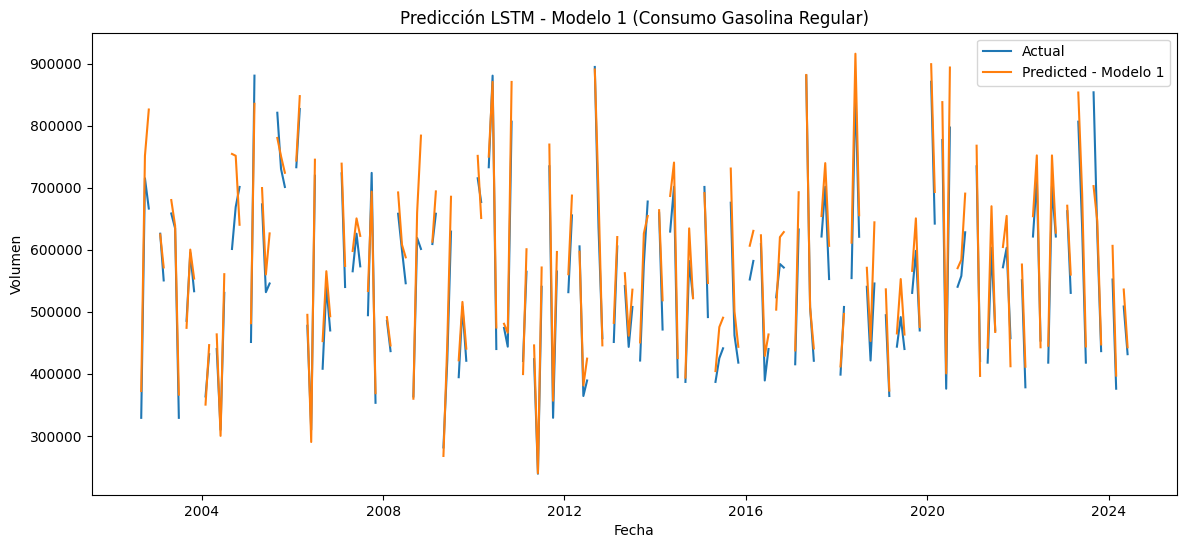

In [59]:
predicciones_consumo_1 = model1_consumo.predict(X_val)
predicciones_consumo_1 = scaler_consumo.inverse_transform(predicciones_consumo_1)
y_val_consumo_1 = scaler_consumo.inverse_transform(y_val.reshape(-1, 1))

plt.figure(figsize=(14, 6))
plt.plot(serie_consumo.index[-len(y_val):], y_val_consumo_1, label='Actual')
plt.plot(serie_consumo.index[-len(y_val):], predicciones_consumo_1, label='Predicted - Modelo 1')
plt.title('Predicción LSTM - Modelo 1 (Consumo Gasolina Regular)')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


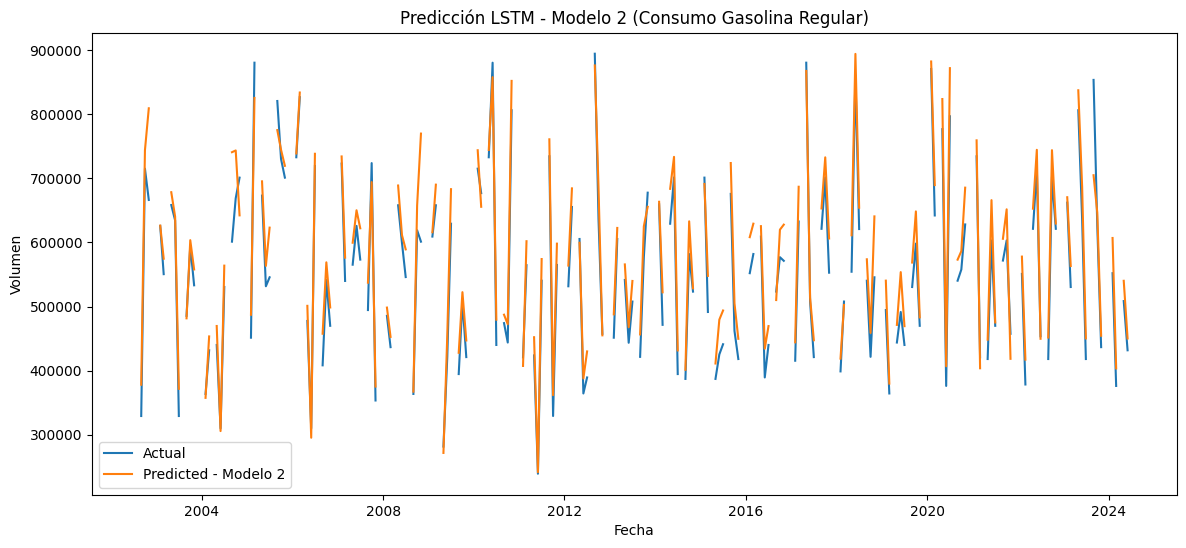

In [60]:
# Predicciones y gráficos para la serie de Consumos - Modelo 2
predicciones_consumo_2 = model2_consumo.predict(X_val)
predicciones_consumo_2 = scaler_consumo.inverse_transform(predicciones_consumo_2)

plt.figure(figsize=(14, 6))
plt.plot(serie_consumo.index[-len(y_val):], y_val_consumo_1, label='Actual')
plt.plot(serie_consumo.index[-len(y_val):], predicciones_consumo_2, label='Predicted - Modelo 2')
plt.title('Predicción LSTM - Modelo 2 (Consumo Gasolina Regular)')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.legend()
plt.show()

### Series de Importaciones

In [52]:
# Entrenamiento de los modelos para la serie de Importaciones
serie_importaciones = importaciones_df2['Gasolina regular'].dropna()

In [53]:
# Modelo 1: LSTM con 50 unidades, 0.2 dropout y 0.001 learning rate
X_train, X_val, y_train, y_val, scaler_importaciones = preprocesar_series(serie_importaciones)
model1_importaciones = construir_modelo_lstm(50, 0.2, 0.001, (X_train.shape[1], X_train.shape[2]))
historia1_importaciones = entrenar_modelo_lstm(X_train, y_train, X_val, y_val, model1_importaciones)


Epoch 1/100


c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.1557 - val_loss: 0.0334
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0251 - val_loss: 0.0223
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0302 - val_loss: 0.0169
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0206 - val_loss: 0.0159
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0172 - val_loss: 0.0076
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0140 - val_loss: 0.0067
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0151 - val_loss: 0.0107
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0158 - val_loss: 0.0066
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0128 - val_loss: 0.0065
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0158 - val_loss: 0.0075
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0133 - val_loss: 0.0066
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0144 - val_loss: 0.0068


In [54]:
# Modelo 2: LSTM con 100 unidades, 0.3 dropout y 0.0005 learning rate
model2_importaciones = construir_modelo_lstm(100, 0.3, 0.0005, (X_train.shape[1], X_train.shape[2]))
historia2_importaciones = entrenar_modelo_lstm(X_train, y_train, X_val, y_val, model2_importaciones)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0.1275 - val_loss: 0.0211
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0236 - val_loss: 0.0195
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0256 - val_loss: 0.0108
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0190 - val_loss: 0.0122
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0147 - val_loss: 0.0067
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0143 - val_loss: 0.0065
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0135 - val_loss: 0.0077
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0132 - val_loss: 0.0072
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0115 - val_loss: 0.0064
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0116 - val_loss: 0.0067
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0124 - val_loss: 0.0077
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0131 - val_l

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


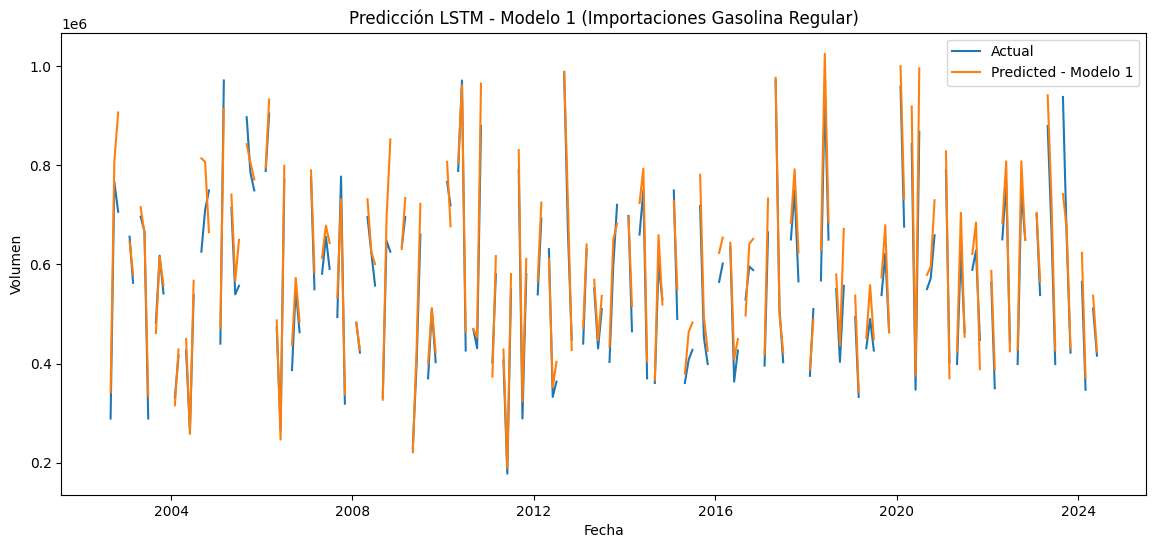

In [61]:
# Predicciones y gráficos para la serie de Importaciones - Modelo 1
predicciones_importaciones_1 = model1_importaciones.predict(X_val)
predicciones_importaciones_1 = scaler_importaciones.inverse_transform(predicciones_importaciones_1)
y_val_importaciones_1 = scaler_importaciones.inverse_transform(y_val.reshape(-1, 1))

plt.figure(figsize=(14, 6))
plt.plot(serie_importaciones.index[-len(y_val):], y_val_importaciones_1, label='Actual')
plt.plot(serie_importaciones.index[-len(y_val):], predicciones_importaciones_1, label='Predicted - Modelo 1')
plt.title('Predicción LSTM - Modelo 1 (Importaciones Gasolina Regular)')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


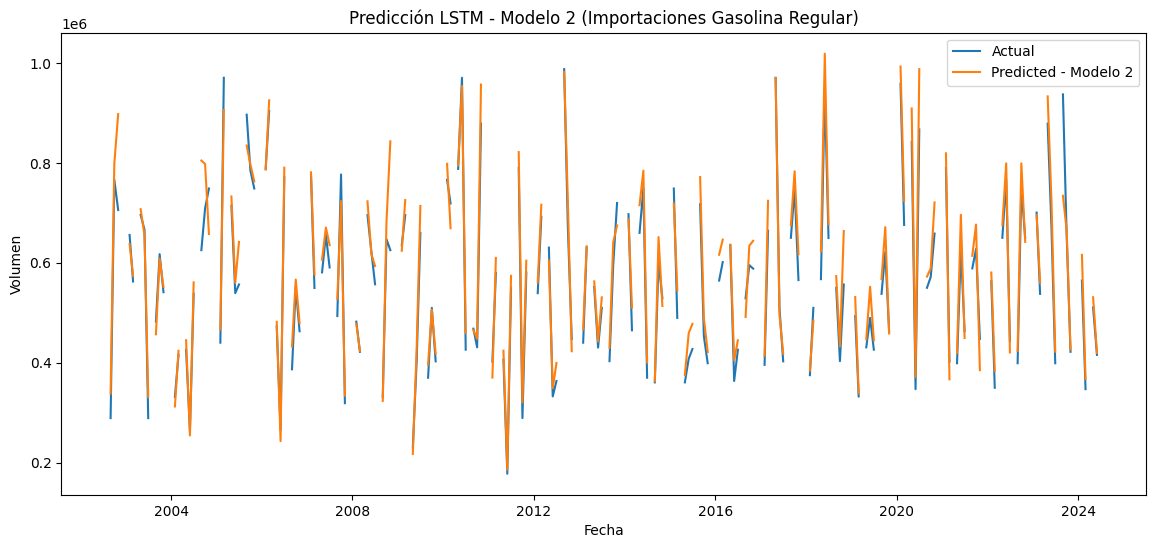

In [62]:
# Predicciones y gráficos para la serie de Importaciones - Modelo 2
predicciones_importaciones_2 = model2_importaciones.predict(X_val)
predicciones_importaciones_2 = scaler_importaciones.inverse_transform(predicciones_importaciones_2)

plt.figure(figsize=(14, 6))
plt.plot(serie_importaciones.index[-len(y_val):], y_val_importaciones_1, label='Actual')
plt.plot(serie_importaciones.index[-len(y_val):], predicciones_importaciones_2, label='Predicted - Modelo 2')
plt.title('Predicción LSTM - Modelo 2 (Importaciones Gasolina Regular)')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.legend()
plt.show()

### Series de Precios

In [55]:
# Entrenamiento de los modelos para la serie de Precios
serie_precios = precios_df2['Gasolina regular'].dropna()


In [56]:
# Modelo 1: LSTM con 50 unidades, 0.2 dropout y 0.001 learning rate
X_train, X_val, y_train, y_val, scaler_precios = preprocesar_series(serie_precios)
model1_precios = construir_modelo_lstm(50, 0.2, 0.001, (X_train.shape[1], X_train.shape[2]))
historia1_precios = entrenar_modelo_lstm(X_train, y_train, X_val, y_val, model1_precios)


c:\Users\rodas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.1338 - val_loss: 0.0038
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0078 - val_loss: 0.0025
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

In [57]:
# Modelo 2: LSTM con 100 unidades, 0.3 dropout y 0.0005 learning rate
model2_precios = construir_modelo_lstm(100, 0.3, 0.0005, (X_train.shape[1], X_train.shape[2]))
historia2_precios = entrenar_modelo_lstm(X_train, y_train, X_val, y_val, model2_precios)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.1081 - val_loss: 0.0038
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0068 - val_loss: 0.0022
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


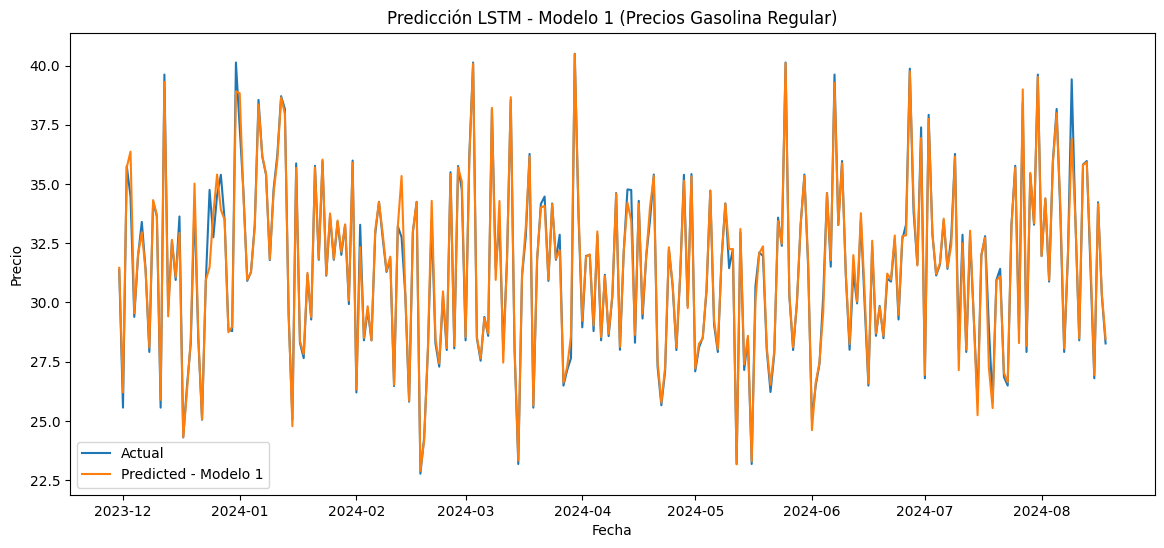

In [63]:
# Predicciones y gráficos para la serie de Precios - Modelo 1
predicciones_precios_1 = model1_precios.predict(X_val)
predicciones_precios_1 = scaler_precios.inverse_transform(predicciones_precios_1)
y_val_precios_1 = scaler_precios.inverse_transform(y_val.reshape(-1, 1))

plt.figure(figsize=(14, 6))
plt.plot(serie_precios.index[-len(y_val):], y_val_precios_1, label='Actual')
plt.plot(serie_precios.index[-len(y_val):], predicciones_precios_1, label='Predicted - Modelo 1')
plt.title('Predicción LSTM - Modelo 1 (Precios Gasolina Regular)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


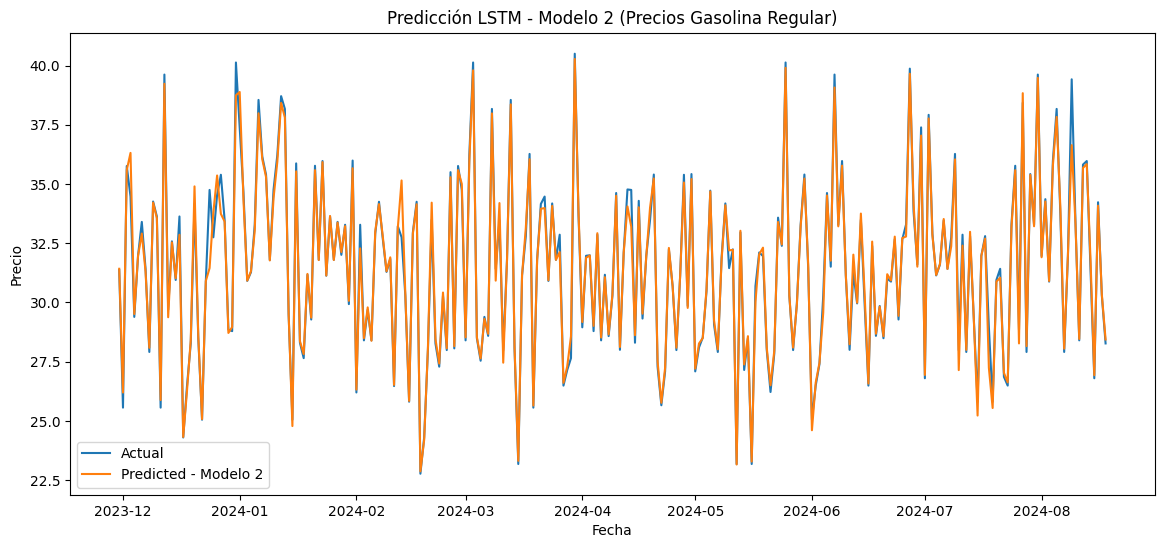

In [64]:
# Predicciones y gráficos para la serie de Precios - Modelo 2
predicciones_precios_2 = model2_precios.predict(X_val)
predicciones_precios_2 = scaler_precios.inverse_transform(predicciones_precios_2)

plt.figure(figsize=(14, 6))
plt.plot(serie_precios.index[-len(y_val):], y_val_precios_1, label='Actual')
plt.plot(serie_precios.index[-len(y_val):], predicciones_precios_2, label='Predicted - Modelo 2')
plt.title('Predicción LSTM - Modelo 2 (Precios Gasolina Regular)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()